In [83]:
import pandas as pd
import h5py
from tqdm import tqdm
import h5py
import numpy as np

# Load Data

In [84]:
filename = '../data/9606.protein.network.embeddings.v12.0 (1).h5'

with h5py.File(filename, 'r') as f:
    meta_keys = f['metadata'].attrs.keys()
    for key in meta_keys:
        print(key, f['metadata'].attrs[key])
    
    embedding = f['embeddings'][:]
    proteins = f['proteins'][:]
    proteins = [p.decode('utf-8') for p in proteins]

# Create DataFrame with one column containing the vector arrays
network_vector_df = pd.DataFrame({
    'embedding_vector': [np.array(vec) for vec in embedding]
}, index=proteins)

enrichment_df = pd.read_csv('../data/9606.protein.enrichment.terms.v12.0.txt.gz', 
                          sep='\t',  
                          compression='gzip')

enrichment_df.set_index('#string_protein_id', inplace=True)

go_categories = [
    'Biological Process (Gene Ontology)',
]

go_enrichment_df = enrichment_df[enrichment_df['category'].isin(go_categories)]


embedding_dim 512
n_proteins 19699
precision 16


# Combine Data

In [85]:
# First create mapping of GO descriptions for proteins that have them
go_descriptions = go_enrichment_df.groupby(level=0)['description'].agg(lambda x: list(set(x)))

# Calculate frequency of each GO term (counting once per protein)
term_frequencies = {}
total_proteins = len(go_descriptions)
for terms in go_descriptions:
    unique_terms = set(terms)
    for term in unique_terms:
        term_frequencies[term] = term_frequencies.get(term, 0) + 1

# Convert to percentages
term_percentages = {term: count/total_proteins for term, count in term_frequencies.items()}

# Find terms that appear in more than 5% of proteins
common_terms = {term for term, percentage in term_percentages.items() if percentage > 0.005}

# Filter out common terms
def filter_common_terms(terms):
    return [term for term in terms if term not in common_terms]

# Apply filtering
filtered_go_descriptions = go_descriptions.apply(filter_common_terms)

# Create binary vectors for remaining terms
all_go_terms = sorted(set(term for terms in filtered_go_descriptions for term in terms))
term_to_idx = {term: idx for idx, term in enumerate(all_go_terms)}

def terms_to_binary_vector(terms):
    vector = [0] * len(all_go_terms)
    if isinstance(terms, (list, set, tuple)):
        for term in terms:
            if term in term_to_idx:
                vector[term_to_idx[term]] = 1
    return vector

# Create vectors for all proteins in network_vector_df
all_protein_vectors = {}
for protein in network_vector_df.index:
    if protein in filtered_go_descriptions:
        all_protein_vectors[protein] = terms_to_binary_vector(filtered_go_descriptions[protein])
    else:
        all_protein_vectors[protein] = [0] * len(all_go_terms)

# Create final DataFrame with all proteins from embedding dataset
final_df = pd.DataFrame({
    'go_vector': list(all_protein_vectors.values())
}, index=list(all_protein_vectors.keys()))

# Print summary statistics
print("Dataset Statistics:")
print(f"Total number of proteins: {len(final_df)}")
print(f"Total number of GO terms after filtering: {len(all_go_terms)}")
print(f"Number of common terms filtered out (>.5%): {len(common_terms)}")

# Calculate how many proteins have no terms
empty_vectors = sum(1 for vec in final_df['go_vector'] if sum(vec) == 0)
print(f"\nProteins with no GO terms: {empty_vectors} ({(empty_vectors/len(final_df))*100:.1f}%)")
print(f"- From missing GO annotations: {len(network_vector_df.index) - len(go_descriptions)}")
print(f"- From filtering: {empty_vectors - (len(network_vector_df.index) - len(go_descriptions))}")

# Calculate distribution of GO terms per protein
terms_per_protein = [sum(vec) for vec in final_df['go_vector']]
print("\nGO terms per protein distribution:")
print(f"Mean: {np.mean(terms_per_protein):.1f}")
print(f"Median: {np.median(terms_per_protein):.1f}")
print(f"Min: {min(terms_per_protein)}")
print(f"Max: {max(terms_per_protein)}")

# Calculate most common remaining terms
term_counts = np.sum([vec for vec in final_df['go_vector']], axis=0)
top_terms_idx = np.argsort(term_counts)[-5:][::-1]
print("\nTop 5 most common remaining terms:")
for idx in top_terms_idx:
    term = [k for k, v in term_to_idx.items() if v == idx][0]
    count = term_counts[idx]
    percentage = (count/len(final_df))*100
    print(f"{term}: {count} proteins ({percentage:.1f}%)")

Dataset Statistics:
Total number of proteins: 19699
Total number of GO terms after filtering: 13889
Number of common terms filtered out (>.5%): 1798

Proteins with no GO terms: 6466 (32.8%)
- From missing GO annotations: 2434
- From filtering: 4032

GO terms per protein distribution:
Mean: 8.7
Median: 3.0
Min: 0
Max: 332

Top 5 most common remaining terms:
Regulation of transcription elongation from RNA polymerase II promoter: 86 proteins (0.4%)
Negative regulation of transporter activity: 86 proteins (0.4%)
Regulation of viral genome replication: 86 proteins (0.4%)
Positive regulation of lipid biosynthetic process: 86 proteins (0.4%)
Transport across blood-brain barrier: 86 proteins (0.4%)


Prepare Data

In [86]:
# Convert list of binary vectors to numpy matrix
go_matrix = np.vstack(final_df['go_vector'])

# Print shape and basic stats
print(f"Matrix shape: {go_matrix.shape}")  # Should be (19699, n_GO_terms)
print(f"Matrix dtype: {go_matrix.dtype}")
print(f"Total number of 1s: {np.sum(go_matrix)}")
print(f"Sparsity: {1 - (np.sum(go_matrix)/(go_matrix.shape[0] * go_matrix.shape[1])):.3f}")  # Fraction of zeros

Matrix shape: (19699, 13889)
Matrix dtype: int64
Total number of 1s: 170870
Sparsity: 0.999


In [87]:
# Take a random sample of proteins for estimation
sample_size = 1000  # or whatever size gives good balance of speed vs accuracy
np.random.seed(42)
sample_indices = np.random.choice(go_matrix.shape[0], sample_size, replace=False)
sample_matrix = go_matrix[sample_indices]

# Calculate shared terms for just this sample
sample_shared = sample_matrix @ sample_matrix.T
sample_pairs_with_shared = np.sum(np.triu(sample_shared > 0, k=1))

# Calculate statistics from sample
sample_possible_pairs = (sample_size * (sample_size - 1)) // 2
sharing_percentage = (sample_pairs_with_shared/sample_possible_pairs)*100

# Extrapolate to full dataset
total_proteins = go_matrix.shape[0]
total_possible_pairs = (total_proteins * (total_proteins - 1)) // 2
estimated_total_pairs = int((sharing_percentage/100) * total_possible_pairs)

print(f"Estimated from {sample_size} protein sample:")
print(f"Estimated proteins sharing terms: {estimated_total_pairs:,} pairs")
print(f"Total possible pairs: {total_possible_pairs:,}")
print(f"Estimated percentage sharing terms: {sharing_percentage:.1f}%")

Estimated from 1000 protein sample:
Estimated proteins sharing terms: 1,405,689 pairs
Total possible pairs: 194,015,451
Estimated percentage sharing terms: 0.7%


Generate Test and Train

In [88]:
import numpy as np

def generate_random_pair(n_proteins):
    while True:
        i = np.random.randint(0, n_proteins)
        j = np.random.randint(0, n_proteins)
        if i < j:  # ensure i < j to avoid duplicates
            return (i, j)
# Define desired sizes
n_train = 50_000  # pairs per class in training set
n_test = 25_000  # pairs per class in test set
n_proteins = go_matrix.shape[0]

pairs_set = set()
nonpairs_set = set()

# Keep sampling until we get enough of each
total_needed = n_train + n_test
while len(pairs_set) < total_needed or len(nonpairs_set) < total_needed:
    i, j = generate_random_pair(n_proteins)
    
    # If we haven't seen this pair before
    if (i, j) not in pairs_set and (i, j) not in nonpairs_set:
        # Check if they share terms
        if np.any(go_matrix[i] & go_matrix[j]):
            if len(pairs_set) < total_needed:
                pairs_set.add((i, j))
        else:
            if len(nonpairs_set) < total_needed:
                nonpairs_set.add((i, j))

# Convert to lists and shuffle
pairs = list(pairs_set)
nonpairs = list(nonpairs_set)
np.random.shuffle(pairs)
np.random.shuffle(nonpairs)

# Split into train and test
train_pairs = pairs[:n_train]
test_pairs = pairs[n_train:total_needed]
train_nonpairs = nonpairs[:n_train]
test_nonpairs = nonpairs[n_train:total_needed]

# Print statistics
print(f"Train positive pairs: {len(train_pairs)}")
print(f"Train negative pairs: {len(train_nonpairs)}")
print(f"Test positive pairs: {len(test_pairs)}")
print(f"Test negative pairs: {len(test_nonpairs)}")

# Store in dictionaries
train_data = {
    'pairs': train_pairs,
    'nonpairs': train_nonpairs
}

test_data = {
    'pairs': test_pairs,
    'nonpairs': test_nonpairs
}

Train positive pairs: 50000
Train negative pairs: 50000
Test positive pairs: 25000
Test negative pairs: 25000


In [101]:
train_set = set(train_pairs + train_nonpairs)
test_set = set(test_pairs + test_nonpairs)
overlap = train_set.intersection(test_set)

print(f"Number of overlapping pairs: {len(overlap)}")
if len(overlap) > 0:
    print("Warning: Found overlapping pairs!")
    print("Example overlapping pairs:", list(overlap)[:5])
else:
    print("No overlap between train and test sets - good to go!")

Number of overlapping pairs: 0
No overlap between train and test sets - good to go!


In [106]:
# Get unique integers from train set tuples
train_ints = set(x for pair in train_pairs + train_nonpairs for x in pair)

# Get unique integers from test set tuples
test_ints = set(x for pair in test_pairs + test_nonpairs for x in pair)

# Find overlap
overlap_ints = train_ints & test_ints

print(f"Number of unique integers in train set: {len(train_ints)}")
print(f"Number of unique integers in test set: {len(test_ints)}")
print(f"Number of integers appearing in both sets: {len(overlap_ints)}")
print(f"Number of integers unique to train set: {len(train_ints - test_ints)}")
print(f"Number of integers unique to test set: {len(test_ints - train_ints)}")

Number of unique integers in train set: 19648
Number of unique integers in test set: 19007
Number of integers appearing in both sets: 18959
Number of integers unique to train set: 689
Number of integers unique to test set: 48


In [110]:
import numpy as np
from tqdm import tqdm  # for progress bars

def generate_random_pair(n_proteins):
    while True:
        i = np.random.randint(0, n_proteins)
        j = np.random.randint(0, n_proteins)
        if i < j:  # ensure i < j to avoid duplicates
            return (i, j)

# First generate 100k pairs of each type
n_pairs = 100_000
n_proteins = go_matrix.shape[0]

print("Generating initial pairs...")
pairs_set = set()
nonpairs_set = set()

with tqdm(total=n_pairs*2) as pbar:
    while len(pairs_set) < n_pairs or len(nonpairs_set) < n_pairs:
        i, j = generate_random_pair(n_proteins)
        
        if (i, j) not in pairs_set and (i, j) not in nonpairs_set:
            if np.any(go_matrix[i] & go_matrix[j]):
                if len(pairs_set) < n_pairs:
                    pairs_set.add((i, j))
                    pbar.update(1)
            else:
                if len(nonpairs_set) < n_pairs:
                    nonpairs_set.add((i, j))
                    pbar.update(1)

# Convert to lists
pairs = list(pairs_set)
nonpairs = list(nonpairs_set)



Generating initial pairs...


100%|██████████| 200000/200000 [04:44<00:00, 703.09it/s] 



Dataset Statistics:
Eval positive pairs: 5000
Eval negative pairs: 5000
Train positive pairs: 3392
Train negative pairs: 3392
Test positive pairs: 848
Test negative pairs: 14561


In [112]:
# Randomly select 0.5% for eval
eval_size = int(0.005 * n_pairs)
eval_indices = np.random.choice(n_pairs, size=eval_size, replace=False)

eval_pairs = [pairs[i] for i in eval_indices]
eval_nonpairs = [nonpairs[i] for i in eval_indices]

# Get proteins used in eval set
eval_proteins = set()
for i, j in eval_pairs + eval_nonpairs:
    eval_proteins.add(i)
    eval_proteins.add(j)

# Filter remaining pairs to remove any traces of eval proteins
remaining_pairs = []
remaining_nonpairs = []

for idx in range(n_pairs):
    if idx not in eval_indices:
        i, j = pairs[idx]
        if i not in eval_proteins and j not in eval_proteins:
            remaining_pairs.append((i, j))
            
        i, j = nonpairs[idx]
        if i not in eval_proteins and j not in eval_proteins:
            remaining_nonpairs.append((i, j))

# Random 80-20 split on remaining data
train_size = int(0.8 * len(remaining_pairs))

np.random.shuffle(remaining_pairs)
np.random.shuffle(remaining_nonpairs)

train_pairs = remaining_pairs[:train_size]
test_pairs = remaining_pairs[train_size:]
train_nonpairs = remaining_nonpairs[:train_size]


test_size = len(test_pairs)  # Use number of positive test pairs as reference
test_nonpairs = test_nonpairs[:test_size]  # Trim negative test pairs to match


# Print statistics
print("\nDataset Statistics:")
print(f"Eval positive pairs: {len(eval_pairs)}")
print(f"Eval negative pairs: {len(eval_nonpairs)}")
print(f"Train positive pairs: {len(train_pairs)}")
print(f"Train negative pairs: {len(train_nonpairs)}")
print(f"Test positive pairs: {len(test_pairs)}")
print(f"Test negative pairs: {len(test_nonpairs)}")

# Store in dictionaries
train_data = {
    'pairs': train_pairs,
    'nonpairs': train_nonpairs
}

eval_data = {
    'pairs': eval_pairs,
    'nonpairs': eval_nonpairs
}

test_data = {
    'pairs': test_pairs,
    'nonpairs': test_nonpairs
}


Dataset Statistics:
Eval positive pairs: 500
Eval negative pairs: 500
Train positive pairs: 52703
Train negative pairs: 52703
Test positive pairs: 13176
Test negative pairs: 13176


Model Train

In [113]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score
import numpy as np
# First prepare our data
def prepare_data(pairs, nonpairs, network_vector_df):
    # Convert all pairs to labels and indices
    all_pairs = [(i, j, 1) for i, j in pairs] + [(i, j, 0) for i, j in nonpairs]
    
    # Convert embeddings to torch tensor
    embeddings = torch.tensor(np.vstack(network_vector_df['embedding_vector'].values), dtype=torch.float32)
    
    return all_pairs, embeddings


# Dataset class
class PairDataset(Dataset):
    def __init__(self, pairs, embeddings):
        self.pairs = pairs
        self.embeddings = embeddings
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        i, j, label = self.pairs[idx]
        return {
            'emb1': self.embeddings[i],
            'emb2': self.embeddings[j],
            'label': torch.tensor(label, dtype=torch.float32)
        }
# at 1% cut off
# Simple element-wise weight model with sigmoid got f1 around 68, 
# with a single nn layer(withresidual connection and dropout)-74. more layers just overfits 
    
class EmbeddingWeights(nn.Module):
    def __init__(self, embedding_dim, dropout_rate=0.2):
        super().__init__()
        self.linear = nn.Linear(embedding_dim, embedding_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, emb1, emb2):
        # Transform embeddings through same network with residual connection
        trans_emb1 = self.linear(emb1)
        trans_emb1 = self.relu(trans_emb1)
        trans_emb1 = self.dropout(trans_emb1)
        trans_emb1 = trans_emb1 + emb1  # residual connection
        
        trans_emb2 = self.linear(emb2)
        trans_emb2 = self.relu(trans_emb2)
        trans_emb2 = self.dropout(trans_emb2)
        trans_emb2 = trans_emb2 + emb2  # residual connection
        
        # Compute cosine similarity and apply sigmoid
        cos_sim = nn.functional.cosine_similarity(trans_emb1, trans_emb2, dim=1)
        return self.sigmoid(cos_sim)

# Simple element-wise weight model with sigmoid
class EmbeddingWeights(nn.Module):
    def __init__(self, embedding_dim=512):  # Fixed method name
        super().__init__()  # Fixed super() call
        self.weights = nn.Parameter(torch.randn(embedding_dim))
        self.sigmoid = nn.Sigmoid()

    def forward(self, emb1, emb2):
        # Apply weights to embeddings
        weighted_emb1 = emb1 * self.weights
        weighted_emb2 = emb2 * self.weights

        # Compute cosine similarity and apply sigmoid
        cos_sim = nn.functional.cosine_similarity(weighted_emb1, weighted_emb2, dim=1)
        return self.sigmoid(cos_sim)

def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0
    criterion = nn.BCELoss()
    
    with torch.no_grad():
        for batch in data_loader:
            output = model(batch['emb1'], batch['emb2'])
            loss = criterion(output, batch['label'])
            total_loss += loss.item()
            
            predictions = (output > 0.5).float()
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(batch['label'].cpu().numpy())
    
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    f1 = f1_score(all_labels, all_preds)
    avg_loss = total_loss / len(data_loader)
    
    return accuracy, f1, avg_loss

def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=1e-4):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()
    
    best_f1 = 0
    best_model = None
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            output = model(batch['emb1'], batch['emb2'])
            loss = criterion(output, batch['label'])
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_acc, train_f1, train_loss = evaluate_model(model, train_loader)
        val_acc, val_f1, val_loss = evaluate_model(model, val_loader)
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model = model.state_dict().copy()
        
        print(f'Epoch {epoch+1}:')
        print(f'Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}')
        print(f'Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}\n')
    
    model.load_state_dict(best_model)
    return model

# Prepare data and train
train_pairs_data, embeddings = prepare_data(train_pairs, train_nonpairs, network_vector_df)
test_pairs_data, _ = prepare_data(test_pairs, test_nonpairs, network_vector_df)

train_dataset = PairDataset(train_pairs_data, embeddings)
test_dataset = PairDataset(test_pairs_data, embeddings)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = EmbeddingWeights()

In [115]:
model = train_model(model, train_loader, test_loader, num_epochs=10)

Epoch 1:
Train - Loss: 0.6560, Acc: 0.6467, F1: 0.6878
Val   - Loss: 0.6566, Acc: 0.6452, F1: 0.6879

Epoch 2:
Train - Loss: 0.6550, Acc: 0.6495, F1: 0.6908
Val   - Loss: 0.6554, Acc: 0.6494, F1: 0.6920

Epoch 3:
Train - Loss: 0.6539, Acc: 0.6512, F1: 0.6932
Val   - Loss: 0.6543, Acc: 0.6508, F1: 0.6935

Epoch 4:
Train - Loss: 0.6528, Acc: 0.6531, F1: 0.6955
Val   - Loss: 0.6532, Acc: 0.6529, F1: 0.6961

Epoch 5:
Train - Loss: 0.6517, Acc: 0.6543, F1: 0.6971
Val   - Loss: 0.6521, Acc: 0.6535, F1: 0.6974

Epoch 6:
Train - Loss: 0.6507, Acc: 0.6555, F1: 0.6988
Val   - Loss: 0.6511, Acc: 0.6540, F1: 0.6984

Epoch 7:
Train - Loss: 0.6497, Acc: 0.6566, F1: 0.7002
Val   - Loss: 0.6500, Acc: 0.6544, F1: 0.6989

Epoch 8:
Train - Loss: 0.6487, Acc: 0.6561, F1: 0.7005
Val   - Loss: 0.6491, Acc: 0.6540, F1: 0.6991

Epoch 9:
Train - Loss: 0.6478, Acc: 0.6565, F1: 0.7012
Val   - Loss: 0.6481, Acc: 0.6549, F1: 0.7000

Epoch 10:
Train - Loss: 0.6470, Acc: 0.6566, F1: 0.7016
Val   - Loss: 0.6472, Acc:

In [116]:
test_acc, test_f1, test_loss = evaluate_model(model, test_loader)
print("\nFinal Test Results:")
print(f"Accuracy: {test_acc:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"Loss: {test_loss:.4f}")


Final Test Results:
Accuracy: 0.6549
F1 Score: 0.7004
Loss: 0.6472


In [117]:
# Prepare evaluation data
eval_pairs_data, _ = prepare_data(eval_pairs, eval_nonpairs, network_vector_df)
eval_dataset = PairDataset(eval_pairs_data, embeddings)
eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False)

# Run evaluation
eval_acc, eval_f1, eval_loss = evaluate_model(model, eval_loader)
print(f'Evaluation Results:')
print(f'Accuracy: {eval_acc:.4f}')
print(f'F1 Score: {eval_f1:.4f}')
print(f'Loss: {eval_loss:.4f}')

Evaluation Results:
Accuracy: 0.6520
F1 Score: 0.6937
Loss: 0.6484


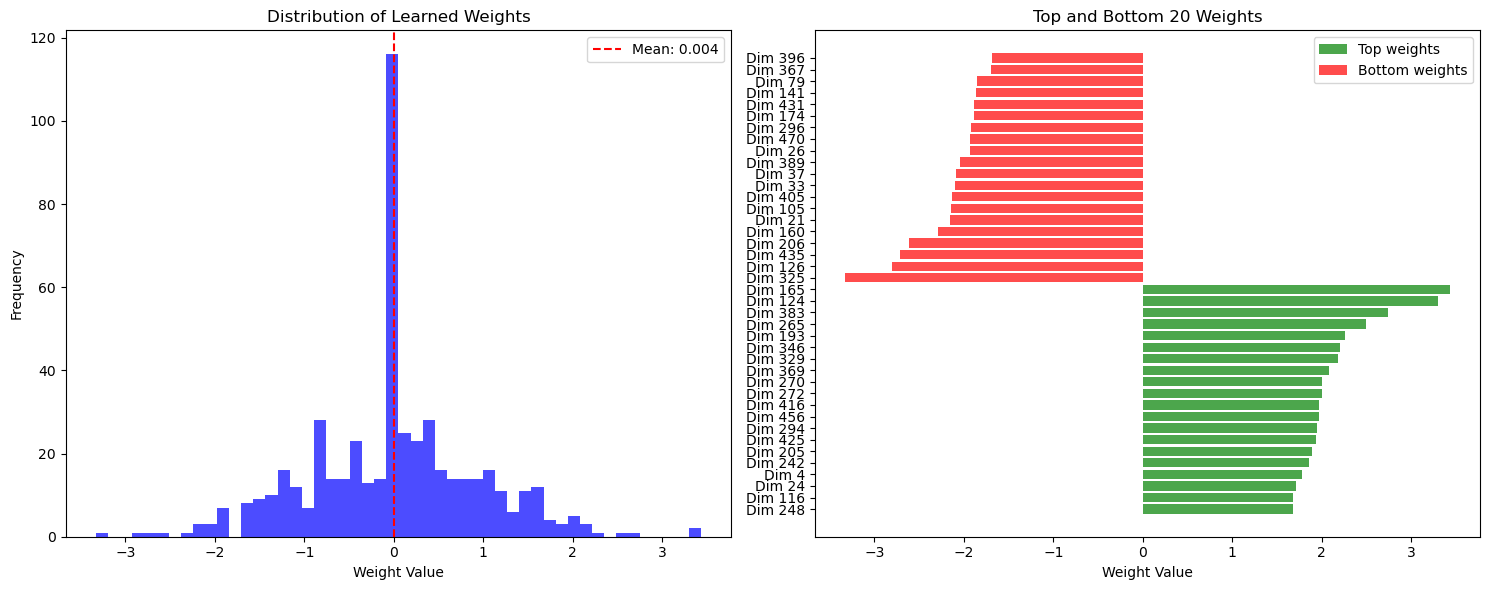


Weight Statistics:
Mean: 0.0035
Std: 0.9550
Min: -3.3268 (Dimension 325)
Max: 3.4324 (Dimension 248)

Number of weights > 0.1: 200
Number of weights < 0.1: 312
Number of weights ≈ 0 (|w| < 0.1): 128


In [118]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the learned weights
learned_weights = model.weights.detach().numpy()


# Sort weights by magnitude for better visualization
sorted_indices = np.argsort(learned_weights)
sorted_weights = learned_weights[sorted_indices]

# Create figure
plt.figure(figsize=(15, 6))

# Main weight distribution plot
plt.subplot(1, 2, 1)
plt.hist(learned_weights, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Learned Weights')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.axvline(x=learned_weights.mean(), color='red', linestyle='--', label=f'Mean: {learned_weights.mean():.3f}')
plt.legend()

# Top/bottom weights plot
plt.subplot(1, 2, 2)
n_top = 20  # number of top/bottom weights to show

# Plot top and bottom weights
plt.barh(range(n_top), sorted_weights[-n_top:], color='green', alpha=0.7, label='Top weights')
plt.barh(range(n_top, 2*n_top), sorted_weights[:n_top], color='red', alpha=0.7, label='Bottom weights')

plt.yticks(range(2*n_top), 
          [f'Dim {sorted_indices[-i-1]}' for i in range(n_top)] + 
          [f'Dim {sorted_indices[i]}' for i in range(n_top)])
plt.title(f'Top and Bottom {n_top} Weights')
plt.xlabel('Weight Value')
plt.legend()

plt.tight_layout()
plt.show()

# Print some summary statistics
print("\nWeight Statistics:")
print(f"Mean: {learned_weights.mean():.4f}")
print(f"Std: {learned_weights.std():.4f}")
print(f"Min: {learned_weights.min():.4f} (Dimension {sorted_indices[0]})")
print(f"Max: {learned_weights.max():.4f} (Dimension {sorted_indices[-1]})")

# Count weights approximately equal to 0
epsilon = 0.1  # You can adjust this threshold as needed
print(f"\nNumber of weights > {epsilon}: {np.sum(learned_weights > epsilon)}")
print(f"Number of weights < {epsilon}: {np.sum(learned_weights < epsilon)}")


zero_weights = np.sum(np.abs(learned_weights) < epsilon)
print(f"Number of weights ≈ 0 (|w| < {epsilon}): {zero_weights}")

In [119]:
np.save('learned_cosine_weights.npy', learned_weights)

non DL approach

In [82]:
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

class DirectOptimizationModel:
    def __init__(self, embedding_dim):
        self.weights = np.ones(embedding_dim)
        
    def predict(self, emb1, emb2):
        # Apply weights
        weighted_emb1 = emb1 * self.weights
        weighted_emb2 = emb2 * self.weights
        
        # Compute cosine similarity
        numerator = np.sum(weighted_emb1 * weighted_emb2, axis=1)
        denominator = (np.linalg.norm(weighted_emb1, axis=1) * 
                      np.linalg.norm(weighted_emb2, axis=1))
        cos_sim = numerator / (denominator + 1e-8)  # Add epsilon for stability
        
        # Apply sigmoid
        predictions = 1 / (1 + np.exp(-cos_sim))
        return predictions
    
    def objective_function(self, weights, emb1, emb2, labels):
        self.weights = weights
        predictions = self.predict(emb1, emb2)
        
        # Compute binary cross-entropy loss
        epsilon = 1e-15
        loss = -np.mean(labels * np.log(predictions + epsilon) + 
                       (1 - labels) * np.log(1 - predictions + epsilon))
        return loss
    
    def fit(self, train_emb1, train_emb2, train_labels, 
            val_emb1=None, val_emb2=None, val_labels=None):
        
        result = minimize(
            lambda w: self.objective_function(w, train_emb1, train_emb2, train_labels),
            self.weights,
            method='L-BFGS-B',
            options={'maxiter': 100}
        )
        
        self.weights = result.x
        return result

def evaluate_direct_model(model, emb1, emb2, labels):
    predictions = model.predict(emb1, emb2)
    binary_preds = (predictions > 0.5).astype(float)
    
    accuracy = np.mean(binary_preds == labels)
    f1 = f1_score(labels, binary_preds)
    
    return accuracy, f1

# Prepare data
def prepare_data_numpy(pairs, nonpairs, embeddings):
    # Combine pairs and nonpairs
    all_pairs = pairs + nonpairs
    labels = np.array([1] * len(pairs) + [0] * len(nonpairs))
    
    # Extract embeddings for each pair
    emb1 = np.vstack([embeddings[i] for i, _ in all_pairs])
    emb2 = np.vstack([embeddings[j] for _, j in all_pairs])
    
    return emb1, emb2, labels

# Main execution
def main():
    # Convert your existing data
    train_emb1, train_emb2, train_labels = prepare_data_numpy(
        train_pairs, train_nonpairs, embeddings.numpy())
    test_emb1, test_emb2, test_labels = prepare_data_numpy(
        test_pairs, test_nonpairs, embeddings.numpy())
    
    # Create and train model
    embedding_dim = embeddings.shape[1]
    model = DirectOptimizationModel(embedding_dim)
    
    # Split train data into train and validation
    (train_emb1_split, val_emb1, train_emb2_split, val_emb2, 
     train_labels_split, val_labels) = train_test_split(
        train_emb1, train_emb2, train_labels, test_size=0.2, random_state=42)
    
    # Fit model
    result = model.fit(train_emb1_split, train_emb2_split, train_labels_split,
                      val_emb1, val_emb2, val_labels)
    
    # Evaluate
    train_acc, train_f1 = evaluate_direct_model(
        model, train_emb1_split, train_emb2_split, train_labels_split)
    val_acc, val_f1 = evaluate_direct_model(
        model, val_emb1, val_emb2, val_labels)
    test_acc, test_f1 = evaluate_direct_model(
        model, test_emb1, test_emb2, test_labels)
    
    print(f"Training - Accuracy: {train_acc:.4f}, F1: {train_f1:.4f}")
    print(f"Validation - Accuracy: {val_acc:.4f}, F1: {val_f1:.4f}")
    print(f"Test - Accuracy: {test_acc:.4f}, F1: {test_f1:.4f}")
    
    return model

if __name__ == "__main__":
    model = main()

Training - Accuracy: 0.6506, F1: 0.6981
Validation - Accuracy: 0.6437, F1: 0.6912
Test - Accuracy: 0.6479, F1: 0.6968
